## **Implementation of shared state subgraphs.**


In [1]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, END, StateGraph
from langchain_ollama import ChatOllama
from typing import TypedDict

In [2]:
class SharedState(TypedDict):
    query: str
    eng_response: str
    hindi_response: str

In [3]:
main_llm = ChatOllama(model="deepseek-v3.1:671b-cloud", temperature=0.7)
sub_llm = ChatOllama(model="deepseek-v3.1:671b-cloud", temperature=0.0)

## designing subgraph


In [4]:
# subgraph node with shared state

def translate_text(state: SharedState):
    prompt = f"""translate the following text to hindi language. do not change the meaning. keep it natural and clear.
    \nTEXT: {state['eng_response']}""".strip()

    response = sub_llm.invoke(prompt)

    return {"hindi_response": response.content}

### **building subgraph**


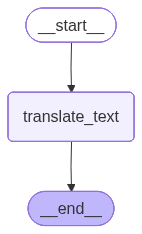

In [5]:
sub_graph = StateGraph(SharedState)

sub_graph.add_node("translate_text", translate_text)
sub_graph.add_edge(START, "translate_text")
sub_graph.add_edge("translate_text", END)

sub_app = sub_graph.compile()
sub_app

## **Building parent graph**


In [6]:
# parent node with shared state

def parent_node(state: SharedState):
    prompt = f"""Answer the following question in english language. be concise and clear.
    \nQUESTION: {state['query']}""".strip()

    response = main_llm.invoke(prompt)

    return {"eng_response": response.content}

In [7]:
# adding memory
memory = MemorySaver()

graph = StateGraph(SharedState)

graph.add_node("parent_node", parent_node)

# integrating subgraph into parent graph
graph.add_node("subgraph_node", sub_app)

graph.add_edge(START, "parent_node")
graph.add_edge("parent_node", "subgraph_node")
graph.add_edge("subgraph_node", END)

## **only add checkpointer to the parent graph**


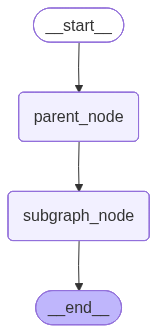

In [8]:
app = graph.compile(checkpointer=memory)
app

In [9]:
config = {"configurable": {
    "thread_id": "thread_123",
}}

response = app.invoke({"query": "why sky is blue?"}, config=config)

In [10]:
print(response["eng_response"])

Sunlight appears white but is made up of all colors of the rainbow. When it enters Earth's atmosphere, the gases and particles scatter the light.

Blue light has a short wavelength and is scattered more easily than other colors like red or yellow. This scattered blue light reaches our eyes from all directions, making the sky look blue.


In [11]:
print(response["hindi_response"])

सूरज की रोशनी सफेद दिखती है लेकिन वह इंद्रधनुष के सभी रंगों से मिलकर बनी होती है। जब यह पृथ्वी के वायुमंडल में प्रवेश करती है, तो गैसों और कणों द्वारा इस प्रकाश का प्रकीर्णन होता है।

नीले रंग की प्रकाश तरंग की लंबाई कम होती है, इसलिए लाल या पीले जैसे अन्य रंगों की तुलना में यह आसानी से बिखर जाती है। यह बिखरा हुआ नीला प्रकाश हर दिशा से हमारी आंखों तक पहुंचता है, जिससे आकाश नीला दिखाई देता है।
